In [1]:
import pandas as pd
from sklearn.metrics.cluster import homogeneity_score
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import v_measure_score,adjusted_rand_score,silhouette_score,davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Custom functions

In [2]:
def purity_score(y_true, y_pred):
    """Purity score
        Args:
            y_true(np.ndarray): n*1 matrix Ground truth labels
            y_pred(np.ndarray): n*1 matrix Predicted clusters

        Returns:
            float: Purity score
    """
    # matrix which will hold the majority-voted labels
    y_voted_labels = np.zeros(y_true.shape)
    # Ordering labels
    ## Labels might be missing e.g with set like 0,2 where 1 is missing
    ## First find the unique labels, then map the labels to an ordered set
    ## 0,2 should become 0,1
    labels = np.unique(y_true)
    ordered_labels = np.arange(labels.shape[0])
    for k in range(labels.shape[0]):
        y_true[y_true==labels[k]] = ordered_labels[k]
    # Update unique labels
    labels = np.unique(y_true)
    # We set the number of bins to be n_classes+2 so that 
    # we count the actual occurence of classes between two consecutive bins
    # the bigger being excluded [bin_i, bin_i+1[
    bins = np.concatenate((labels, [np.max(labels)+1]), axis=0)

    for cluster in np.unique(y_pred):
        hist, _ = np.histogram(y_true[y_pred==cluster], bins=bins)
        # Find the most present label in the cluster
        winner = np.argmax(hist)
        y_voted_labels[y_pred==cluster] = winner

    return accuracy_score(y_true, y_voted_labels)

In [3]:
def silhouette_plot(X, y, n_clusters, ax=None):
    from sklearn.metrics import silhouette_samples, silhouette_score
    import matplotlib.cm as cm

    if ax is None:
        ax = plt.gca()

    # Compute the silhouette scores for each sample
    silhouette_avg = silhouette_score(X, y)
    sample_silhouette_values = silhouette_samples(X, y)

    y_lower = padding = 2
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        ith_cluster_silhouette_values = sample_silhouette_values[y == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0,
                         ith_cluster_silhouette_values,
                         facecolor=color,
                         edgecolor=color,
                         alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i ))

        # Compute the new y_lower for next plot
        y_lower = y_upper + padding

    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax.axvline(x=silhouette_avg, c='r', alpha=0.8, lw=0.8, ls='-')
    ax.annotate('Average',
                xytext=(silhouette_avg, y_lower * 1.025),
                xy=(0, 0),
                ha='center',
                alpha=0.8,
                c='r')

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_ylim(0, y_upper + 1)
    ax.set_xlim(-0.075, 1.0)
    return ax

In [4]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt

#Draw a 95.4% (if n_std=2) elipse corresponding to the covariance matrix 
def confidence_ellipse(x, y, ax, n_std=2.0, edgecolor='none', **kwargs):

    cov = np.cov(x, y)
    lambda_, v = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_)
    ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                  width=lambda_[0]*n_std*2, height=lambda_[1]*n_std*2,
                  angle=np.rad2deg(np.arccos(v[0, 0])),edgecolor=edgecolor)
    ell.set_facecolor("none")
    return  ax.add_patch(ell)

In [5]:
#a function to draw the maximum elements in the table bold
def highlight_max(s):    
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

# Import the Data

In [6]:
data = pd.read_csv('cancer.csv')
data.head(2)

,Clump_Thickness,Cell_Size_Uniformity,Cell_Shape_Uniformity,Marginal_Adhesion,Single_Epi_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Bare_Nuclei.1,Class
0,7,4,5,10,2,10.0,3,8,2,malignant
1,5,3,4,1,4,1.0,3,1,1,benign


In [7]:
X, y = data.drop('Class',axis=1) , data['Class']
y_color = y.map({' malignant':'red',' benign':'green'})
y = y.map({' malignant':1,' benign':0})

# Testing the hypothesis that the dataset is divided into two clusters like the number of classes

From all the metrics used to find the number of appropriate clusters, we chose the Inertia

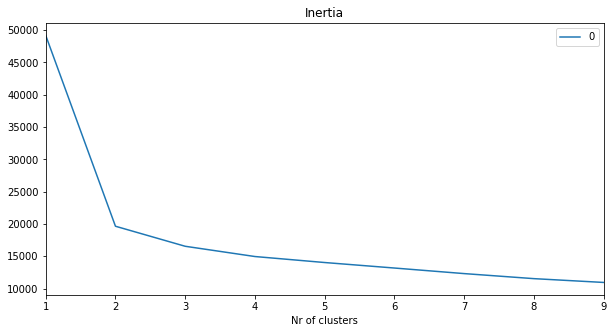

In [8]:
inertia = []
for n in range(1 , 10):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X)
    inertia.append(algorithm.inertia_)

fig, ax = plt.subplots(figsize=(10, 5))    
pd.DataFrame(inertia).plot(title = "Inertia",ax=ax)
_ = ax.set_xlabel("Nr of clusters")
_ = ax.set_xticklabels([1,2,3,4,5,6,7,8,9])


According to the Kmeans' inertia, 2 clusters seem to be a good hypothesis

# Applying some Dimentionality Reduction for plotting

In [9]:
pca2d = PCA(n_components=2)
pca3d = PCA(n_components=3)

In [11]:
pca_fitted2d = pca2d.fit_transform(X)
pca_fitted3d = pca3d.fit_transform(X)

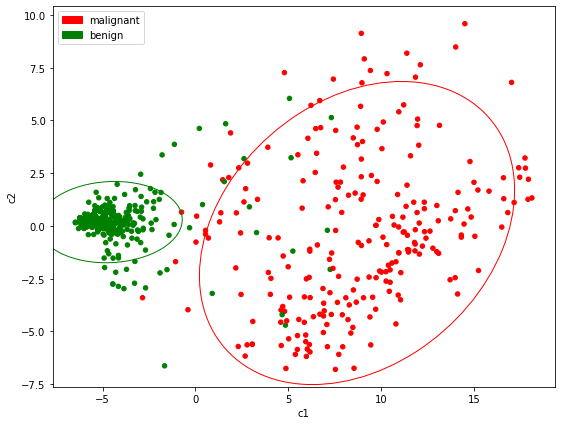

In [13]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt



pca_fitted = pd.DataFrame(pca_fitted2d,columns = ['c1','c2']).join(y)
#^this is a pandas Dataframe which is good for printing, manipulating columns and plotting, as we do bellow

fig, ax = plt.subplots(figsize=(9, 7)) #create a matplotlib figure   
pca_fitted.plot.scatter('c1','c2',c=y_color,ax=ax)#draw in the figure ax

#Add the legends
red_patch = mpatches.Patch(color='red', label='malignant')
green_patch = mpatches.Patch(color='green', label='benign')
ax.legend(handles=[red_patch,green_patch])

#draw the elipses with the function defined in the begining
confidence_ellipse(pca_fitted2d[y==1,0], pca_fitted2d[y==1,1], ax, edgecolor='red')
confidence_ellipse(pca_fitted2d[y==0,0], pca_fitted2d[y==0,1], ax, edgecolor='green')


In [14]:
#sometimes it is hard to install this library, so there is not much need to run this cell. It just draws an interactive
#3D plot that helps strengthening the hypothesis
import chart_studio.plotly as py 
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
fig = go.Figure(go.Scatter3d(
    x = pca_fitted3d[:,0],
    y = pca_fitted3d[:,1],
    z = pca_fitted3d[:,2],
    mode = 'markers',
    marker=dict(
        color=y_color,
        size=4)
))

fig.update_layout(scene = dict(
                    xaxis_title='C1',
                    yaxis_title='C2',
                    zaxis_title='C3'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

The 3D Plot does not show any additional information about the two clusters, so, the 2 first principal components might be enough to explain the clusters

# Testing hierarchical clusterings



In [15]:
#Given a X a true_y and a predicted_y this function returns all the metrics (internal and external) that we will use
def get_all_metrics(y,y_pred,X):
    return silhouette_score(X,y_pred),davies_bouldin_score(X,y_pred), v_measure_score(y,y_pred),purity_score(y,y_pred),adjusted_rand_score(y,y_pred)

#fits an Agglomerative Clustering for a X and y, appends the metrics to the vector results_table and returns the labels.
def cluster_analysis(X,y,affinity = 'euclidean', linkage='ward',plot=True,confidence_elipse = False):
    try:
        model = AgglomerativeClustering(n_clusters=2, affinity=affinity, linkage=linkage)
        model.fit(X)
        labels = model.labels_
        
        results_table.append(get_all_metrics(y,labels,X))
        columns.append(f'{affinity} + {linkage}')#appends a string of the current configuration to an outside vector

        cmap = {0:'r',1:'g'}
        c =[cmap[l] for l in labels]
        
        if plot == True:
            fig, ax = plt.subplots(figsize=(9, 7)) 
            red_patch = mpatches.Patch(color='red', label='cluster 0')
            green_patch = mpatches.Patch(color='green', label='cluster 1')
            ax.legend(handles=[red_patch,green_patch])
            pca_fitted.plot.scatter('c1','c2',c=c,title = f"{affinity} + {linkage}",ax=ax)
            if(confidence_elipse==True):
                confidence_ellipse(pca_fitted2d[labels==1,0], pca_fitted2d[labels==1,1], ax, edgecolor='red')
                confidence_ellipse(pca_fitted2d[labels==0,0], pca_fitted2d[labels==0,1], ax, edgecolor='green')
            plt.show()
        return labels
    except:
        pass

## - Testing different linkage:
    Single, complete, average, ward
## - And distance measures:
    euclidean, l1, l2, manhattan, cosine
   (If linkage is "ward", only "euclidean" is accepted.)
## - Check if it is the same groups that appear

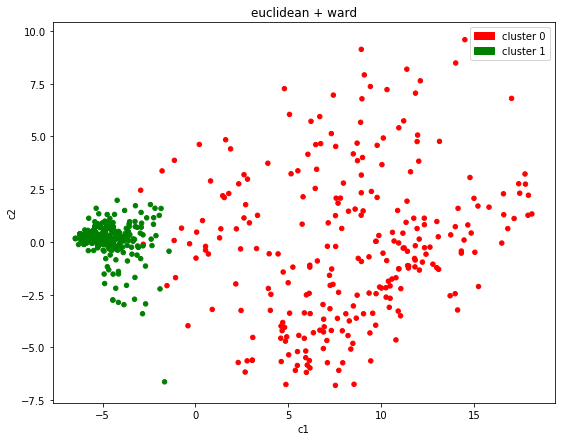

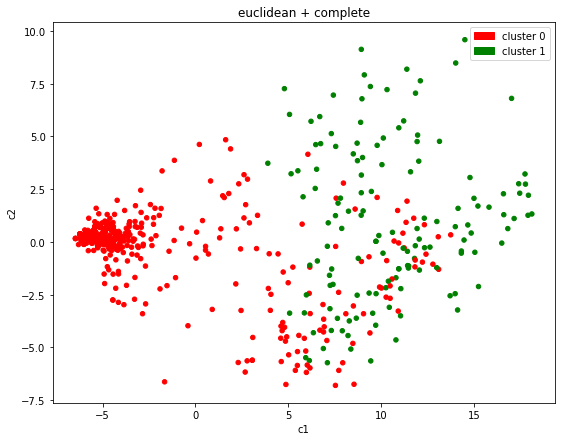

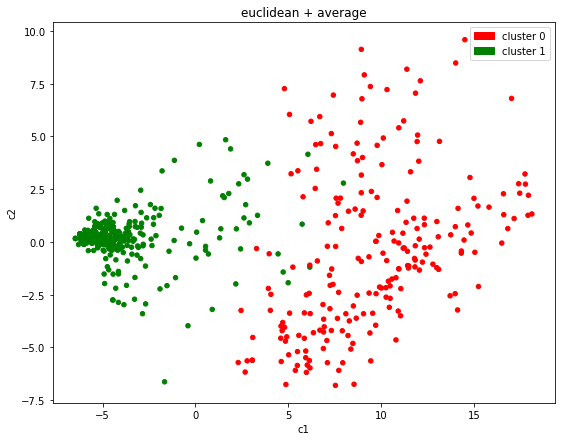

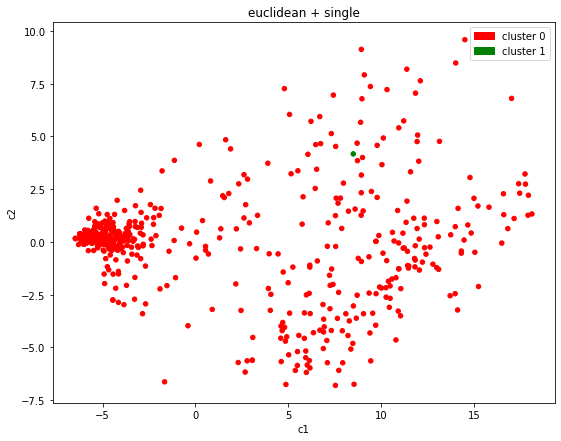

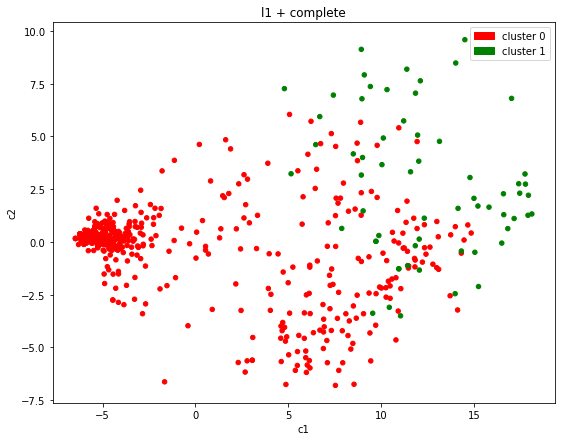

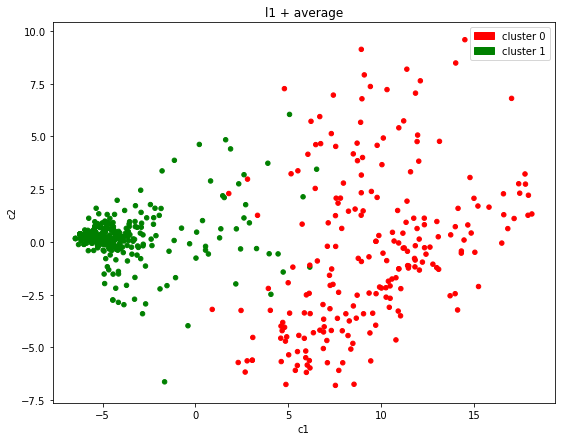

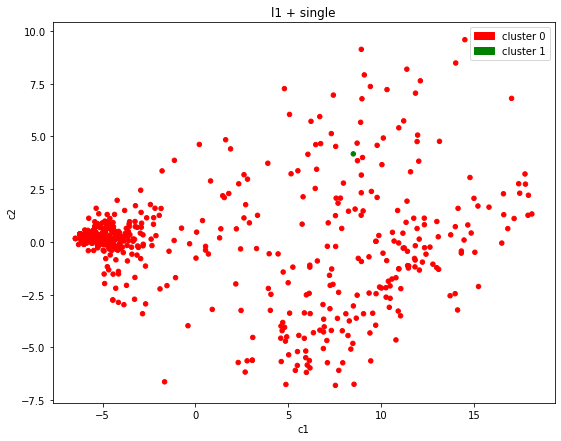

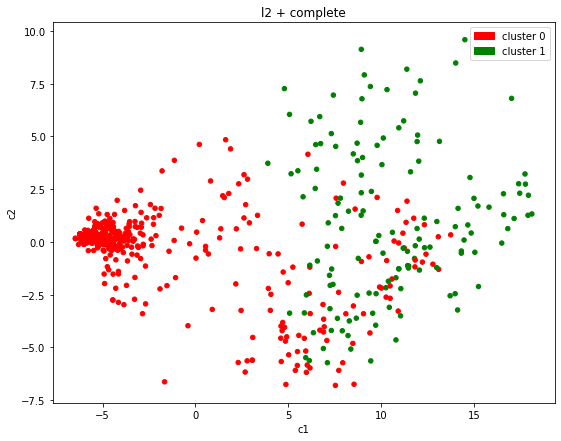

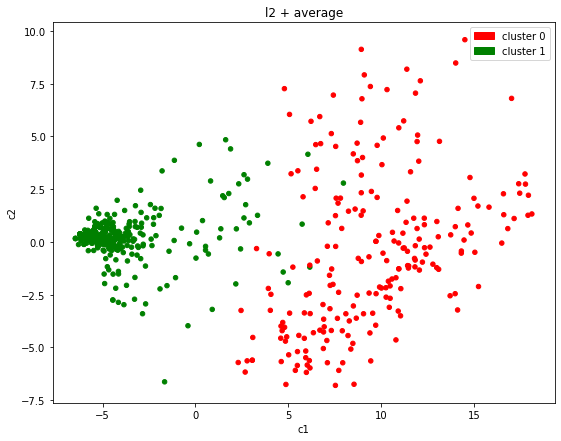

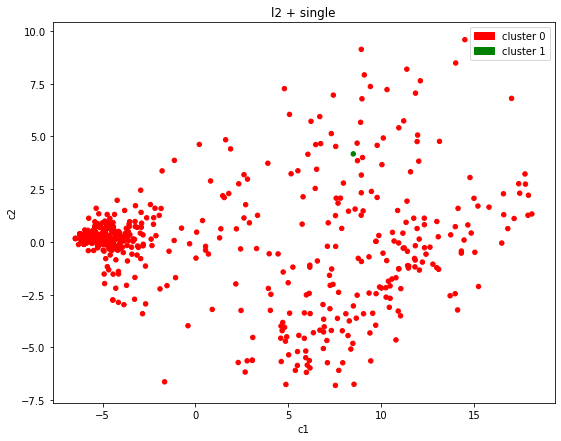

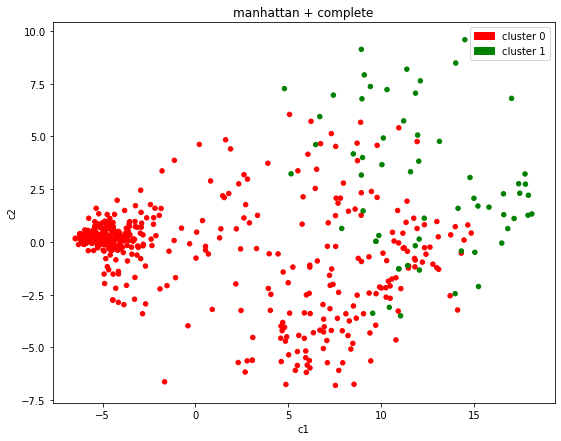

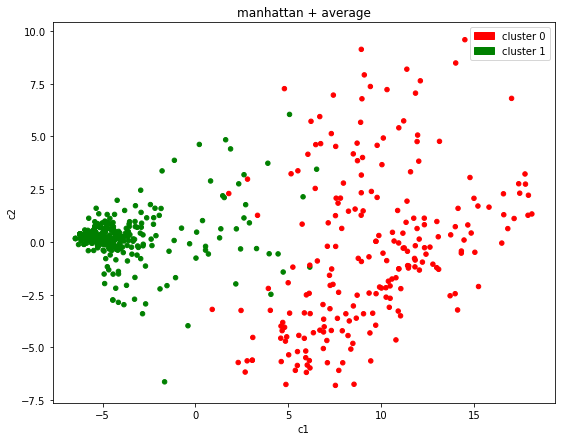

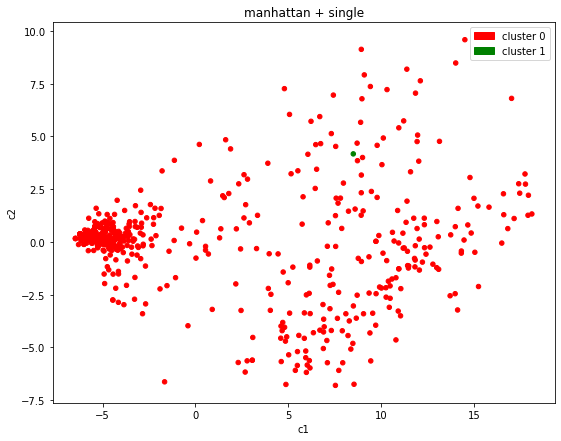

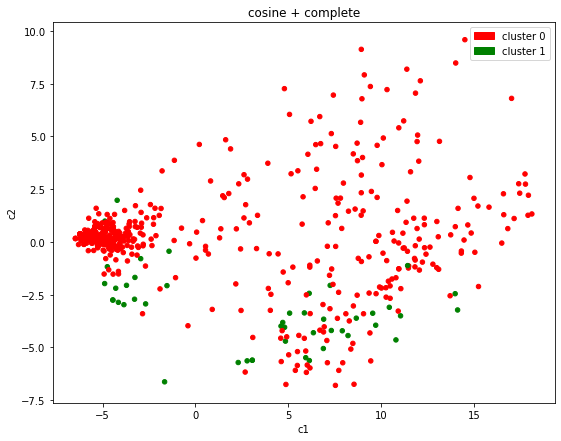

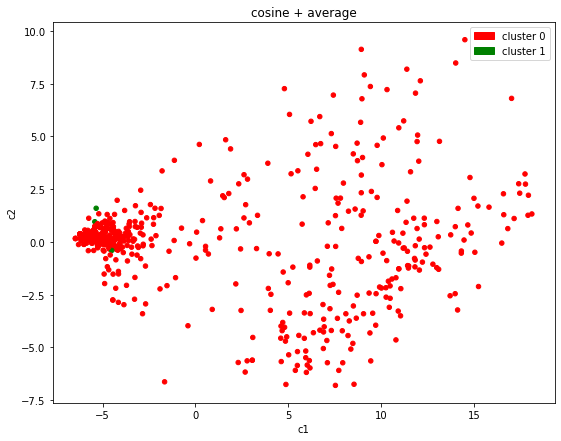

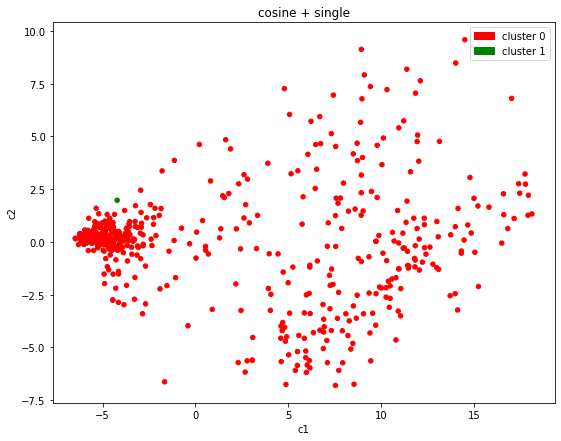

In [16]:
results_table = []
columns = []
for a in ["euclidean", "l1", "l2","manhattan", "cosine"]:
    for l in ["ward", "complete", "average", "single"]:
        cluster_analysis(X,y,a,l)

There are many configurations that seem to resemble the true classes.
## Quantifying the best results

In [21]:
#drawing the results in an html table


results2 = pd.DataFrame(np.transpose(results_table),columns =columns,index=['silhouette','davies_bouldin', 'v_measure','purity','adjusted_rand'])
#ordering the columns according to the average score of all the scores and getting the best 4 configurations
results2 = results2[results2.apply(np.mean).sort_values(ascending=False).index]

#Plot and ake the maximum element of each column bold 
results2.style.apply(highlight_max,axis=1)


,euclidean + ward,manhattan + average,l1 + average,l2 + average,euclidean + average,cosine + complete,l2 + complete,euclidean + complete,manhattan + complete,l1 + complete,cosine + average,cosine + single,manhattan + single,l2 + single,l1 + single,euclidean + single
silhouette,0.570553,0.589637,0.589637,0.590208,0.590208,0.173094,0.494748,0.494748,0.440063,0.440063,-0.0277377,0.132295,0.409158,0.409158,0.409158,0.409158
davies_bouldin,0.788219,0.777294,0.777294,0.774513,0.774513,2.68204,0.96773,0.96773,1.02334,1.02334,1.18191,0.81542,0.487355,0.487355,0.487355,0.487355
v_measure,0.799834,0.697764,0.697764,0.673144,0.673144,0.0194308,0.389461,0.389461,0.199795,0.199795,0.00541617,0.00184861,0.00465787,0.00465787,0.00465787,0.00465787
purity,0.965665,0.948498,0.948498,0.942775,0.942775,0.666667,0.839771,0.839771,0.741059,0.741059,0.655222,0.655222,0.656652,0.656652,0.656652,0.656652
adjusted_rand,0.866426,0.801797,0.801797,0.781014,0.781014,0.0411186,0.441802,0.441802,0.178521,0.178521,-0.00401054,-0.00135483,0.00257475,0.00257475,0.00257475,0.00257475


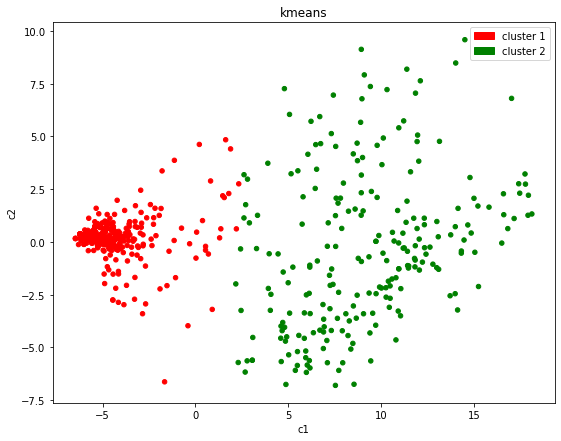

,euclidean + ward,Kmeans,l1 + average,manhattan + average,euclidean + average,l2 + average,cosine + complete,euclidean + complete,l2 + complete,l1 + complete,manhattan + complete,cosine + average,cosine + single,l1 + single,l2 + single,manhattan + single,euclidean + single
silhouette,0.570553,0.597166,0.589637,0.589637,0.590208,0.590208,0.173094,0.494748,0.494748,0.440063,0.440063,-0.0277377,0.132295,0.409158,0.409158,0.409158,0.409158
davies_bouldin,0.788219,0.758858,0.777294,0.777294,0.774513,0.774513,2.68204,0.96773,0.96773,1.02334,1.02334,1.18191,0.81542,0.487355,0.487355,0.487355,0.487355
v_measure,0.799834,0.742724,0.697764,0.697764,0.673144,0.673144,0.0194308,0.389461,0.389461,0.199795,0.199795,0.00541617,0.00184861,0.00465787,0.00465787,0.00465787,0.00465787
purity,0.965665,0.959943,0.948498,0.948498,0.942775,0.942775,0.666667,0.839771,0.839771,0.741059,0.741059,0.655222,0.655222,0.656652,0.656652,0.656652,0.656652
adjusted_rand,0.866426,0.8444,0.801797,0.801797,0.781014,0.781014,0.0411186,0.441802,0.441802,0.178521,0.178521,-0.00401054,-0.00135483,0.00257475,0.00257475,0.00257475,0.00257475


In [22]:
kmeans = KMeans(n_clusters=2,n_init=10).fit(X)
labels_km = kmeans.labels_

results2 = results2.join(pd.Series(get_all_metrics(y,labels_km,X),name = 'Kmeans',index = results2.index))
results2 = results2[results2.apply(np.mean).sort_values(ascending=False).index]



cmap = {0:'r',1:'g',2:'b',3:'c'}
c_km =[cmap[l] for l in labels_km]
fig, ax = plt.subplots(figsize=(9, 7)) 
red_patch = mpatches.Patch(color='red', label='cluster 1')
green_patch = mpatches.Patch(color='green', label='cluster 2')
ax.legend(handles=[red_patch,green_patch])
pca_fitted.plot.scatter('c1','c2',c=c_km,title='kmeans',ax=ax)
#confidence_ellipse(pca_fitted2d[labels==1,0], pca_fitted2d[labels==1,1], ax, edgecolor='red')
#confidence_ellipse(pca_fitted2d[labels==0,0], pca_fitted2d[labels==0,1], ax, edgecolor='green')

plt.show()

#Plot and ake the maximum element of each column bold 
results2.style.apply(highlight_max,axis=1)

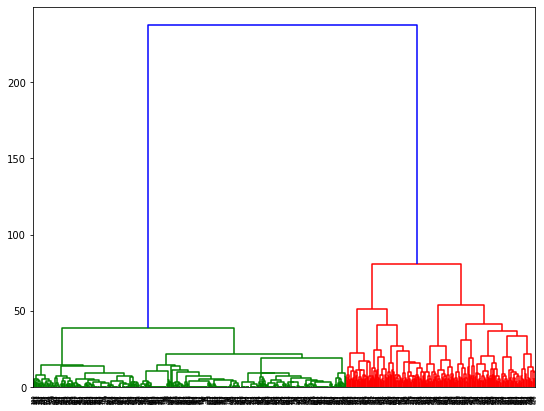

In [44]:
fig, ax = plt.subplots(figsize=(9, 7)) 
dendrogram = sch.dendrogram(sch.linkage(X, method='ward', metric='euclidean'),ax=ax)


According to the height of the splits in the dendogram of the best configuration of clustering, the hypothesis of 2 clusters that correspond approximatly to the true classes is confirmed

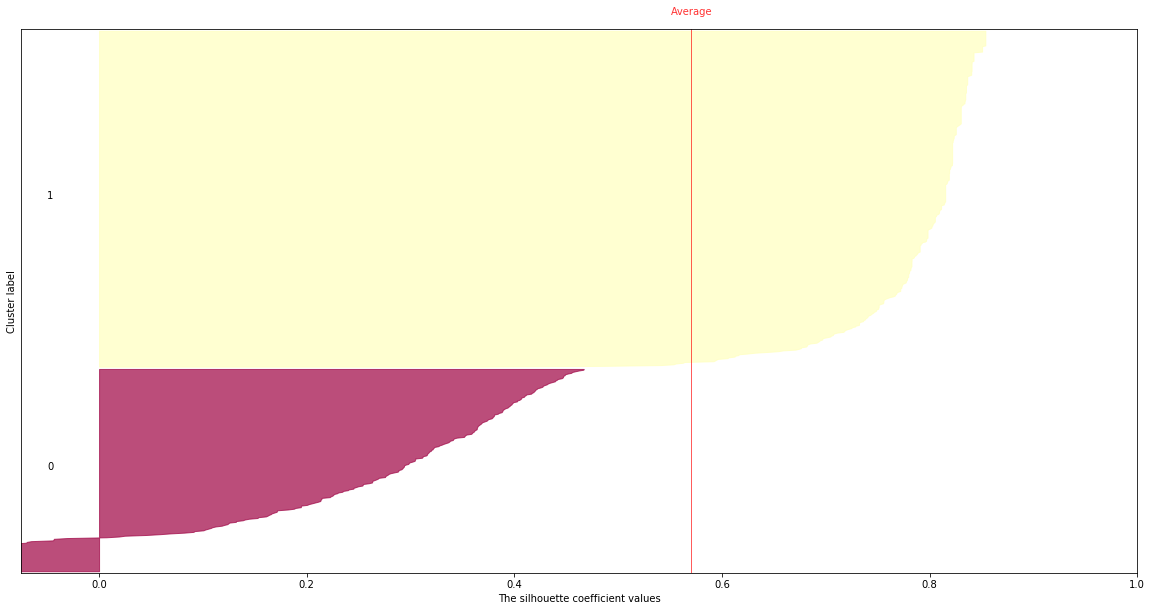

In [45]:
fig, ax = plt.subplots(figsize=(20, 10))
silhouette_plot(X, cluster_labels, 2,ax)

Which by analyzing the plot of the best configuration is understandable, since the cluster 0 has much more variance, and there are many red points closer to the mean of cluster 1 than to the mean of cluster0 (even though we are aware that the distances we see in the plot are distorted because of the PCA

# Robustness

In [33]:
#calculate the centroids of the Kmeans clustering
centroids = X.copy()
cluster_labels = cluster_analysis(X,y,plot=False) #getting the labels of the best configuration
centroids['cluster']=cluster_labels #add that column to the dataframe centroids
centroids = centroids.groupby('cluster').mean()#calculate the centroids
centroids= centroids.sort_index(ascending=False).reset_index()#change the order of the rows
centroids

,cluster,Clump_Thickness,Cell_Size_Uniformity,Cell_Shape_Uniformity,Marginal_Adhesion,Single_Epi_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Bare_Nuclei.1
0,1,2.846330,1.188073,1.321101,1.259174,2.004587,1.228073,1.995413,1.107798,1.057339
1,0,7.022814,6.361217,6.334601,5.372624,5.224335,7.300152,5.828897,5.783270,2.471483


In [34]:
#calculate the centroids of the Kmeans clustering
kmeans_centroids = pd.DataFrame(kmeans.cluster_centers_,columns=X.columns)
kmeans_centroids

,Clump_Thickness,Cell_Size_Uniformity,Cell_Shape_Uniformity,Marginal_Adhesion,Single_Epi_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Bare_Nuclei.1
0,3.032328,1.295259,1.435345,1.338362,2.088362,1.306983,2.092672,1.247845,1.109914
1,7.153191,6.765957,6.706383,5.706383,5.442553,7.867830,6.093617,6.063830,2.536170


In [43]:
error = (((centroids-kmeans_centroids)/centroids)*100).mean().mean()
print(f"The kmeans centroids have a mean error of {error}% in relation to the Hierarchical Clustering centroids" )

The kmeans centroids have a mean error of -5.991644548848008% in relation to the Hierarchical Clustering centroids


# Intepreting the obtained cluster with a decision tree

In [46]:
clf = tree.DecisionTreeClassifier(criterion="entropy")
clf = clf.fit(X, cluster_labels)

In [47]:
X.columns[np.argsort(-clf.feature_importances_)]

Index(['Cell_Size_Uniformity', 'Normal_Nucleoli', 'Bare_Nuclei',
       'Clump_Thickness', 'Marginal_Adhesion', 'Bland_Chromatin',
       'Bare_Nuclei.1', 'Cell_Shape_Uniformity', 'Single_Epi_Cell_Size'],
      dtype='object')

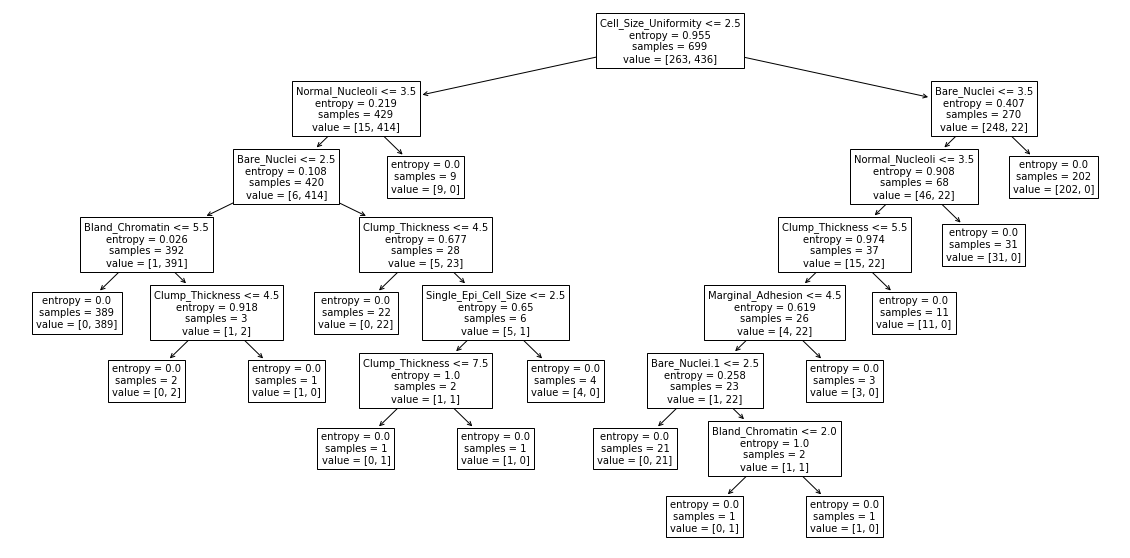

In [48]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 10))
txt = tree.plot_tree(clf.fit(X, cluster_labels),fontsize=10,ax=ax,feature_names=X.columns)

In [51]:
#This is a plot that is more visually appealing, but is harder to configure. The one below is the one we put in the report
"""
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import os

os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\pkgs\graphviz-2.38.0-h6538335_1011\Library\bin\graphviz"

dtree=tree.DecisionTreeClassifier(criterion='entropy')
dtree.fit(X,cluster_labels)

dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=X.columns,
                class_names=['Malign', 'Benign'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
"""
print(" ")#just to clear the output